# Application of GPcounts with Negative Binomial likelihood on Brain visium data from 10xGenomics to identify spatially expressed genes.

This Jupyter Notebook will focus on analyzing spatially-resolved RNA-seq data within Scanpy.  It will cover the following tasks:
* Selection and Filtration of cells based on QC metrics
* Normalization
* Dimensional reduction and clustering
* Calculate the scale factors
* Correct for the library size
* identify spatially variable genes

First, we load GPcounts and the other necessary packages.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import squidpy as sq
import pandas as pd 
import gpflow
import tensorflow as tf
from GPcounts import NegativeBinomialLikelihood
from GPcounts.GPcounts_Module import Fit_GPcounts

In [18]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.7.5
scanpy      1.6.1.dev132+gcea278dd
sinfo       0.3.1
-----
GPcounts                            NA
PIL                                 8.1.0
absl                                NA
anndata                             0.7.5
anyio                               NA
appnope                             0.1.2
astunparse                          1.6.3
attr                                20.3.0
babel                               2.9.0
backcall                            0.2.0
bs4                                 4.9.3
cairo                               1.20.0
certifi                             2020.12.05
cffi                                1.14.4
chardet                             4.0.0
cloudpickle                         1.6.0
constants                           NA
cycler                              0.10.0
cython_runtime                      NA
dask                                2021.01.0
dateutil                            2.8.1
decorator                           4

## Reading the data

Read in the count matrix into an AnnData object that contains counts, images and spatial coordinates. The data used was generated by 10xGenomics, which can be found here: https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Human_Brain_Section_1. We will calculate standards QC metrics with pp.calculate_qc_metrics and percentage of mitochondrial read counts per sample.

In [5]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Brain_Section_1")
adata.var_names_make_unique() # To make sure gene names are unique
adata.var["mt"] = adata.var_names.str.startswith("MT-") # get mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

reading /Users/phuong/data/V1_Human_Brain_Section_1/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
adata

AnnData object with n_obs × n_vars = 4910 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

## Quality Control and preprocessing 

We perform some basic filtering of spots based on total counts and expressed genes. 

__Thresholding decision:__ counts and genes

/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

<AxesSubplot:xlabel='n_genes_by_counts'>

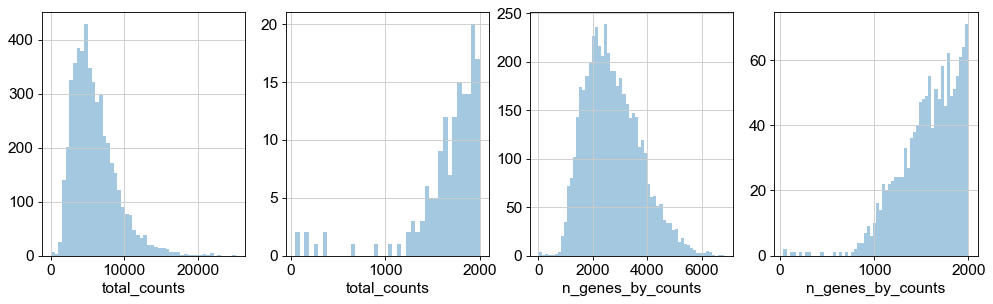

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 2000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 2000], kde=False, bins=60, ax=axs[3])

... storing 'feature_types' as categorical
... storing 'genome' as categorical


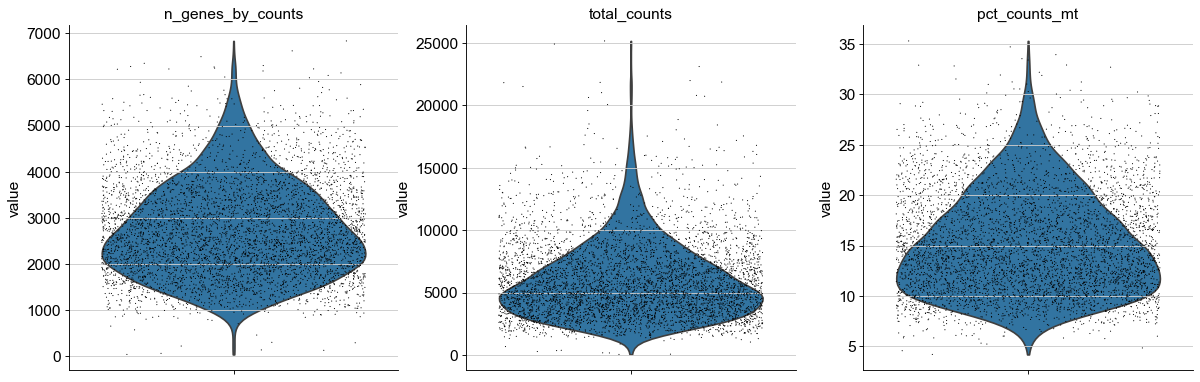

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

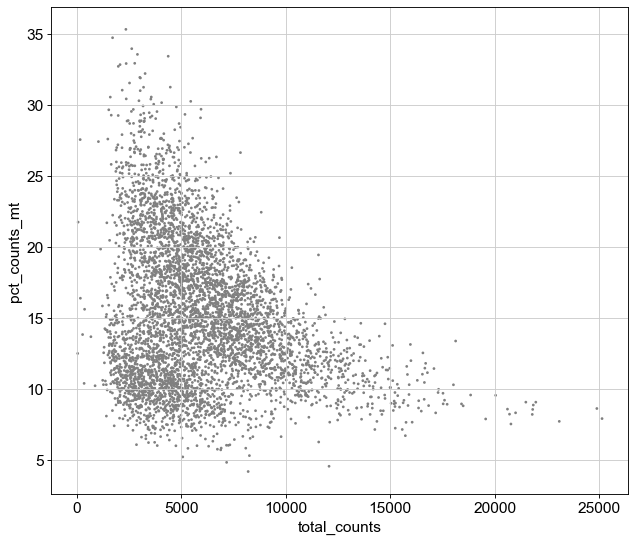

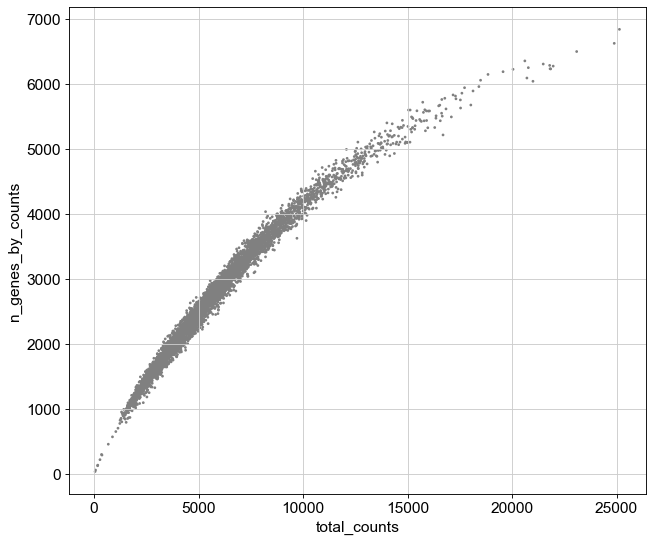

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, max_counts=20000)
adata = adata[adata.obs["pct_counts_mt"] < 30]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10) # Min 10 cells - filters out 0 count genes

filtered out 32 cells that have less than 1500 counts
/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 13 cells that have more than 20000 counts
/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#cells after MT filter: 4840


filtered out 17850 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.


We proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes (for later). 

In [11]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## Manifold embedding and clustering based on transcriptional similarity

In [13]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

computing PCA
    on highly variable genes
/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 8 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


# GPcounts_spatial

Using GPcounts with Negative Binomial likelihood on visium data to identify spatially expressed genes.

In [40]:
adata.obsm['spatial']
spatialx = [str(i) for i in adata.obsm['spatial'][:,0]] 
spatialy = [str(i) for i in adata.obsm['spatial'][:,1]] 

In [41]:
index_names = [i + 'x' + j for i, j in zip(spatialx, spatialy)] 

In [42]:
# spatial expression counts matrix
Y = pd.DataFrame(data = adata.X.A, index = index_names, columns = adata.var_names)
Y

,AL627309.1,AL627309.5,LINC01409,LINC01128,LINC00115,FAM41C,LINC02593,SAMD11,NOC2L,KLHL17,...,MT-ND5,MT-ND6,MT-CYB,AC145212.1,MAFIP,AC011043.1,AL354822.1,AC240274.1,AC007325.4,AC007325.2
8210x14537,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.545994,0.000000,3.158367,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
16323x3296,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.448079,0.000000,3.935525,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
19620x16692,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,3.276142,1.431311,4.119028,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
9311x5925,0.0,0.0,0.0,0.471175,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.915301,0.790160,4.341676,0.471175,0.0,0.471175,0.0,0.0,0.00000,0.0
20995x12865,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.903383,0.942693,4.036440,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16458x16452,0.0,0.0,0.0,0.821396,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.620072,0.492765,3.912750,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
18107x16931,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,2.215078,0.459328,3.533147,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
18521x13343,0.0,0.0,0.0,0.716560,0.0,0.0,0.0,0.0,0.716560,0.0,...,2.876839,1.129709,3.895475,0.000000,0.0,0.000000,0.0,0.0,0.71656,0.0
16594x20040,0.0,0.0,0.0,0.727356,0.0,0.0,0.0,0.0,0.428401,0.0,...,2.257254,0.428401,3.634984,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0


After filtering, the whole data-set contains 18,751 genes but for simplicity we run this example on the highly variable genes.

In [43]:
genes = adata[:,adata.var.highly_variable].var_names.values

/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [44]:
Y = Y[genes]

In [45]:
spatial_locations = pd.DataFrame(index=Y.index)
spatial_locations['x'] = Y.index.str.split('x').str.get(0).map(float)
spatial_locations['y'] = Y.index.str.split('x').str.get(1).map(float)

In [46]:
spatial_locations['total_counts'] = Y.sum(1)
Y = Y.loc[spatial_locations.index]
X = spatial_locations[['x', 'y']]

To correct for the library size of the spatial samples, we normalise our data by multiplying the mean by a location specific scale factor. To calculate the scale factors we perform negative binomial regression with identity link function using statsmodels package.

In [47]:
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
# scales = []
# for i in range(0,len(Y.columns)):
#     model = smf.glm(formula = "Y.iloc[:,i]~0+spatial_locations['total_counts']", data = Y, family = sm.families.NegativeBinomial(sm.families.links.identity())).fit()
#     res = model.params[0]*spatial_locations['total_counts']
#     scales.append(res)
#     scalesdf=pd.DataFrame(scales)
# scalesdf=scalesdf.T
# print(scalesdf)
# scalesdf.to_csv('scales_nb_highly_variable.csv', sep="\t")

The calculation will take some time, therefore we provide a file (scales_nb_highly_variable.csv) with the all spatially expressed genes found by running GPcounts on the highly variable genes.

In [49]:
scale = pd.read_csv('scales_nb_highly_variable.csv', sep="\t")
del scale['Unnamed: 0']

In [50]:
scale

,total_counts,total_counts.1,total_counts.2,total_counts.3,total_counts.4,total_counts.5,total_counts.6,total_counts.7,total_counts.8,total_counts.9,...,total_counts.1990,total_counts.1991,total_counts.1992,total_counts.1993,total_counts.1994,total_counts.1995,total_counts.1996,total_counts.1997,total_counts.1998,total_counts.1999
0,0.003581,0.011873,0.053312,0.338222,0.103459,0.122171,0.002634,0.281306,0.049365,0.133146,...,0.004871,0.017516,0.010807,0.004090,0.028840,0.013489,0.004956,0.018836,0.015247,8.197477
1,0.002340,0.007759,0.034840,0.221031,0.067612,0.079840,0.001721,0.183836,0.032261,0.087012,...,0.003183,0.011447,0.007062,0.002673,0.018847,0.008816,0.003238,0.012310,0.009964,5.357127
2,0.002312,0.007666,0.034421,0.218377,0.066800,0.078881,0.001701,0.181628,0.031873,0.085967,...,0.003145,0.011309,0.006978,0.002640,0.018621,0.008710,0.003200,0.012162,0.009844,5.292798
3,0.001750,0.005801,0.026046,0.165242,0.050546,0.059688,0.001287,0.137435,0.024118,0.065050,...,0.002380,0.008558,0.005280,0.001998,0.014090,0.006590,0.002421,0.009203,0.007449,4.004959
4,0.001432,0.004747,0.021313,0.135212,0.041360,0.048841,0.001053,0.112459,0.019735,0.053228,...,0.001947,0.007002,0.004320,0.001635,0.011530,0.005393,0.001981,0.007530,0.006095,3.277141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,0.001576,0.005226,0.023466,0.148874,0.045539,0.053776,0.001159,0.123821,0.021729,0.058606,...,0.002144,0.007710,0.004757,0.001800,0.012695,0.005938,0.002181,0.008291,0.006711,3.608255
4836,0.001687,0.005594,0.025116,0.159339,0.048741,0.057556,0.001241,0.132526,0.023257,0.062726,...,0.002295,0.008252,0.005091,0.001927,0.013587,0.006355,0.002335,0.008874,0.007183,3.861909
4837,0.001187,0.003934,0.017666,0.112075,0.034283,0.040483,0.000873,0.093215,0.016358,0.044120,...,0.001614,0.005804,0.003581,0.001355,0.009557,0.004470,0.001642,0.006242,0.005052,2.716359
4838,0.001615,0.005356,0.024050,0.152577,0.046672,0.055113,0.001188,0.126901,0.022270,0.060064,...,0.002197,0.007902,0.004875,0.001845,0.013010,0.006085,0.002236,0.008497,0.006878,3.698013


In [51]:
Y = Y.T
Y_run = Y 
X = X[['x', 'y']]

Because the visium data set is computationally expensive we use the sparse version of the GPcounts code. Hence, we calculate the number of inducing points using `sp.special.wrightomega()`from scipy. It is suggested to use more than that.

In [52]:
import scipy as sp
sp.special.wrightomega(np.log(X.shape[0]))

6.597916137305535

To run the scaled version of the GPcounts, where the negative binomial mean is multiplied by the pre-culculated scale factors, we should use the three optional arguments in the function `Fit_GPcounts`: `scale=scale` and `nb_scale`. The `scale` argument contains the file with the scale factors, the `nb_scaled=True` argument is used to activate the scaled (multiplicative) version. To implement the sparse version, we need to pass the `sparse` argument into Fit_GPcounts and the number of inducing points `M`.

In [53]:
gene_name = []
sparse = True
nb_scaled = True # set the nb_scaled argument to True to pass the scale factors
gene_name = Y_run.index
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y_run.loc[gene_name], scale = scale, sparse = sparse,nb_scaled=nb_scaled,safe_mode=False,M = 8)

We run the One_sample_test with negative binomial likelihood for the 2000 highly variable genes. The results will show the following:
* Name of the gene
* Dynamic_model_log_likelihood - Likelihood of the dynamic model
* Constant_model_log_likelihood - Likelihood of the constant ('null') model
* log_likelihood_ratio - Ratio between the dynamic and constant models
* p value - statistical significance based on P value
* q value - Statistical significance based on the "adjusted p value" for the false discovery rate or q value

In [54]:
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|██████████| 2000/2000 [14:23:05<00:00, 25.89s/it]   


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
LINC02593,-809.510613,-776.644905,-32.865707
SAMD11,-1809.021082,-1689.534350,-119.486733
MXRA8,-4525.722318,-3959.871102,-565.851216
VWA1,-20855.211680,-20808.657297,-46.554383
ATAD3B,-5335.238975,-5188.455117,-146.783858
...,...,...,...
AC006157.1,-1586.673480,-1466.803735,-119.869745
LINC00278,-558.123937,-509.428819,-48.695118
TMSB4Y,-1762.680752,-1615.289924,-147.390828
TTTY10,-1204.201718,-1027.852263,-176.349456


In [55]:
results = gp_counts.calculate_FDR(log_likelihood_ratio)
results

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
LINC02593,-809.510613,-776.644905,-32.865707,1.0,1.0
SAMD11,-1809.021082,-1689.534350,-119.486733,1.0,1.0
MXRA8,-4525.722318,-3959.871102,-565.851216,1.0,1.0
VWA1,-20855.211680,-20808.657297,-46.554383,1.0,1.0
ATAD3B,-5335.238975,-5188.455117,-146.783858,1.0,1.0
...,...,...,...,...,...
AC006157.1,-1586.673480,-1466.803735,-119.869745,1.0,1.0
LINC00278,-558.123937,-509.428819,-48.695118,1.0,1.0
TMSB4Y,-1762.680752,-1615.289924,-147.390828,1.0,1.0
TTTY10,-1204.201718,-1027.852263,-176.349456,1.0,1.0


Rerunning takes a lot of time. The results can be found in the file results.csv.

In [58]:
# results = pd.read_csv('results.csv', sep="\t")

# Filter and Visualization of significant SVG

In [158]:
gp_svg = results[results['q_value'] < 0.05]
gp_svg.sort_values("q_value")

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
MMEL1,-457.305706,-515.646525,58.340819,0.000000e+00,0.000000e+00
ZFC3H1,-20035.868120,-20276.931364,241.063244,0.000000e+00,0.000000e+00
CPM,-7891.436953,-8466.722794,575.285841,0.000000e+00,0.000000e+00
LLPH,-14793.929686,-15000.873236,206.943550,0.000000e+00,0.000000e+00
ERBB3,-19093.332985,-20000.131395,906.798411,0.000000e+00,0.000000e+00
...,...,...,...,...,...
IWS1,-22682.850278,-22701.703301,18.853023,8.224925e-10,2.921821e-09
OLR1,-9166.513683,-9177.694385,11.180702,2.258678e-06,8.009495e-06
GLIS2-AS1,-915.435774,-926.595025,11.159251,2.309706e-06,8.175950e-06
ZFHX4,-14657.991432,-14667.817907,9.826475,9.285979e-06,3.281265e-05


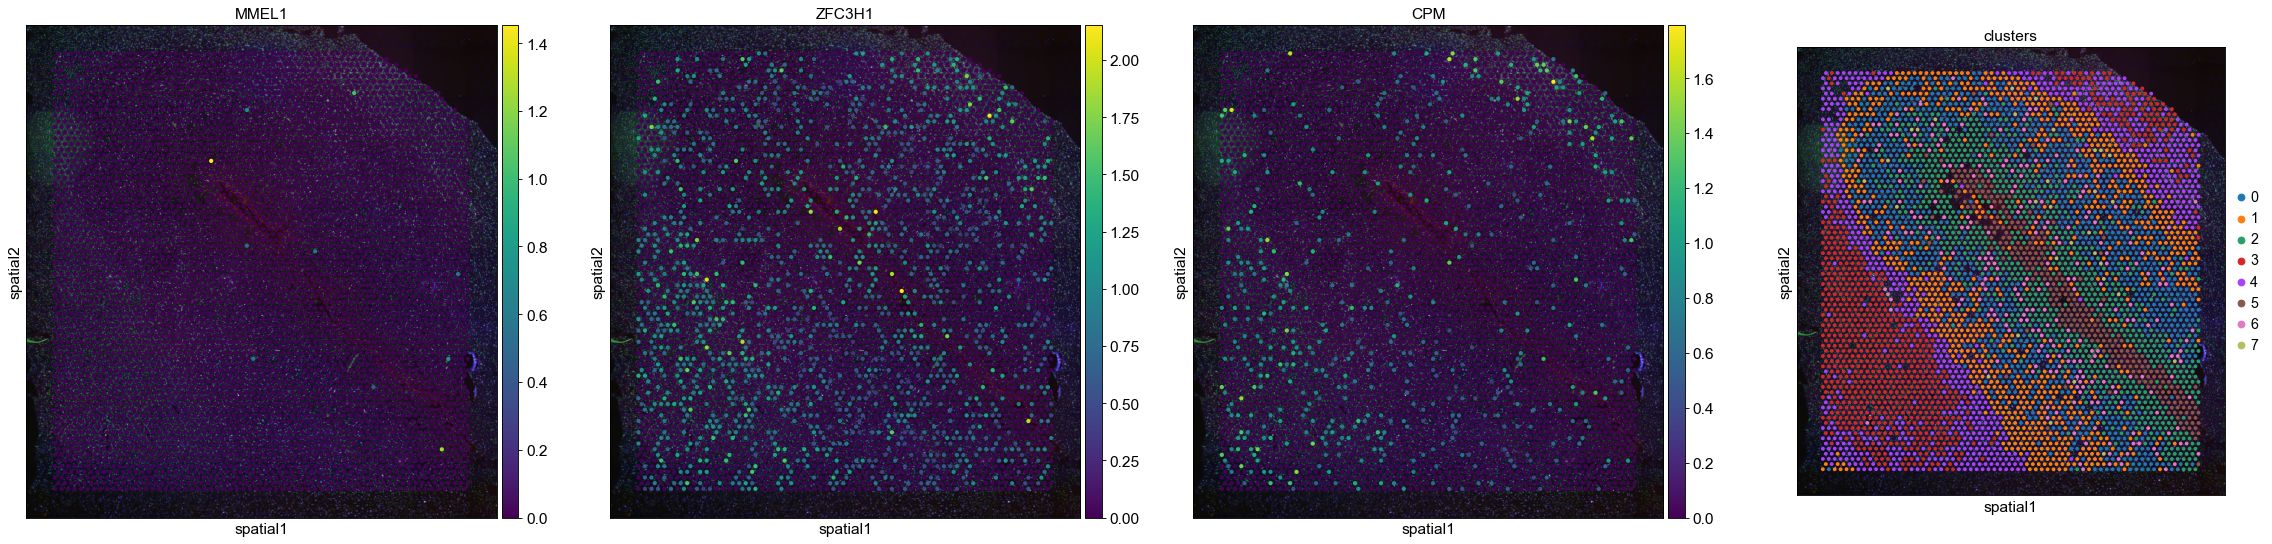

In [150]:
sc.pl.spatial(adata, img_key="hires",  color=["MMEL1", "ZFC3H1", "CPM", "clusters"])

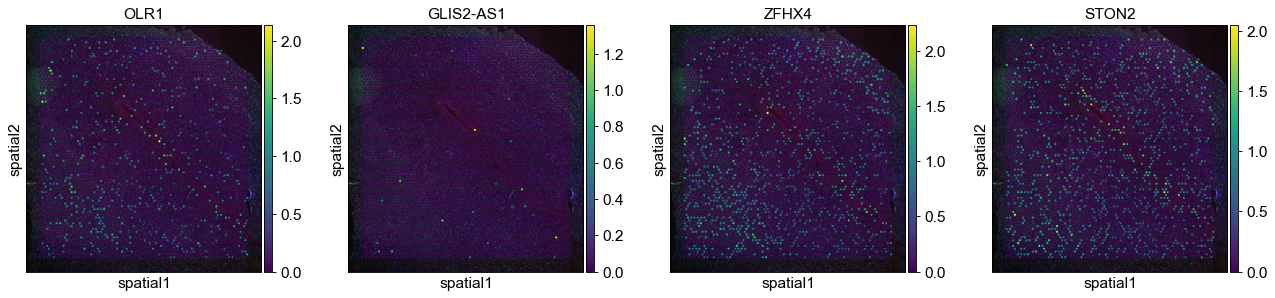

In [16]:
sc.pl.spatial(adata, img_key="hires",  color=["OLR1", "GLIS2-AS1", "ZFHX4", "STON2"])